<a href="https://colab.research.google.com/github/BeltranMal/TA047R-2C2024-GRUPO01/blob/main/TA047R_TP1_GRUPO01_ENTREGA_EJ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Análisis Exploratorio y preprocesamiento de datos
*   Realizar el análisis de datos mínimo necesario para comprender el dominio del problema.
*   Limpieza de datos.
*   Generación de nuevos features, etc.



In [205]:
estambul = pd.read_csv('/content/drive/MyDrive/TA047R-2C2024-GRUPO01/listings.csv')
estambul.last_review = pd.to_datetime(estambul.last_review)

In [206]:
estambul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31758 entries, 0 to 31757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              31758 non-null  int64         
 1   name                            31758 non-null  object        
 2   host_id                         31758 non-null  int64         
 3   host_name                       31758 non-null  object        
 4   neighbourhood_group             0 non-null      float64       
 5   neighbourhood                   31758 non-null  object        
 6   latitude                        31758 non-null  float64       
 7   longitude                       31758 non-null  float64       
 8   room_type                       31758 non-null  object        
 9   price                           29232 non-null  float64       
 10  minimum_nights                  31758 non-null  int64         
 11  nu

In [207]:
# Analizamos dimensiones
estambul.shape

(31758, 18)

In [208]:
# Analizamos duplicados
estambul.duplicated().sum()

0

In [209]:
# Analizamos porcentaje de nulos
estambul.isna().sum() / estambul.shape[0] * 100

,0
id,0.000000
name,0.000000
host_id,0.000000
host_name,0.000000
neighbourhood_group,100.000000
neighbourhood,0.000000
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,7.953901


In [210]:
# La columna neighbourhood_group tiene 100% de datos nulos, decidimos eliminarla
estambul.drop(columns={"neighbourhood_group"}, inplace=True)

In [211]:
# Limpieza de datos
columnas_nulos = estambul.columns[estambul.isna().any()].tolist()
for col in columnas_nulos:
  if estambul[col].dtype in ['int64', 'float64']:
    estambul[col] = estambul[col].fillna(estambul[col].median())
  elif estambul[col].dtype == "datetime64[ns]":
    estambul[col] = estambul[col].interpolate()
    if estambul[col].isna().sum().sum() > 0:
      estambul[col] = estambul[col].bfill()
  else:
    estambul[col] = estambul[col].fillna("desconocido")

In [212]:
# Generacion de nuevas features
estambul.last_review = pd.to_datetime(estambul.last_review)
estambul["mes_last_review"] = estambul.last_review.dt.month
estambul["year_last_review"] = estambul.last_review.dt.year
estambul["dia_last_review"] = estambul.last_review.dt.day

# Ultima review de hace mas de 3 años  se considera lugar descontinuado
activos = ((estambul["year_last_review"] == 2021) & (estambul["mes_last_review"] >= 6) | (estambul["year_last_review"] > 2021))
estambul.loc[:, "descontinuado"] = 1
estambul.loc[activos, "descontinuado"] = 0

In [213]:
# Sacamos los lugares descontinuados
estambul = estambul.loc[estambul.descontinuado == 0]

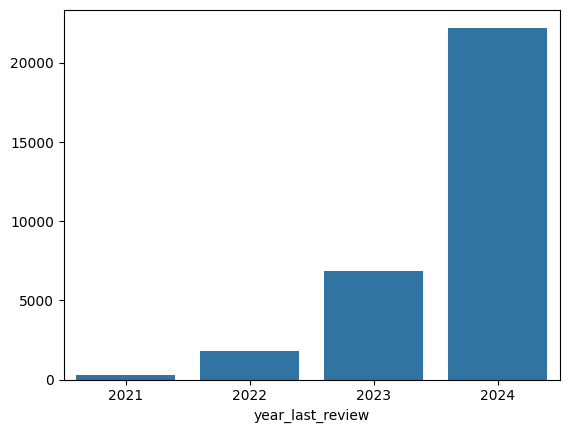

In [214]:
datos_por_year = estambul.groupby("year_last_review").last_review.count()
sns.barplot(x=datos_por_year.index, y=datos_por_year.values)
plt.show()

In [215]:
estambul.drop(columns={"last_review"}, inplace=True)

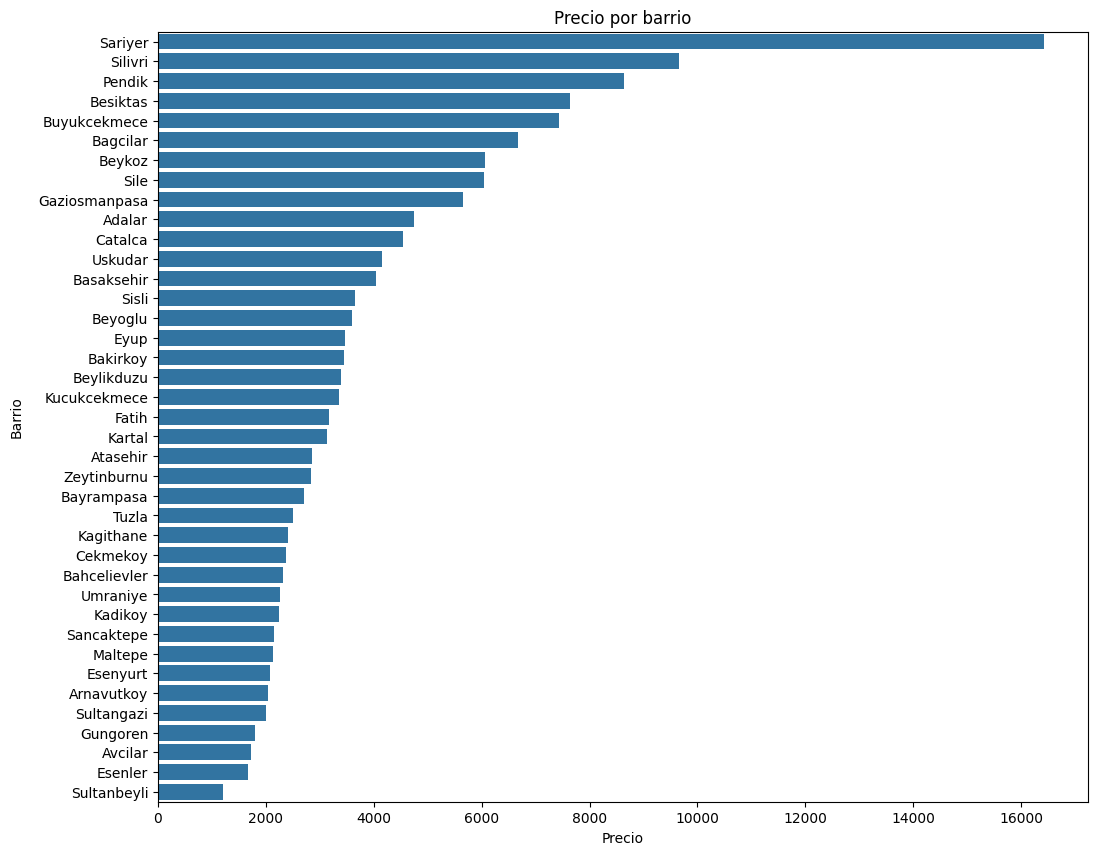

In [216]:
plt.figure(figsize=(12,10))
precio_por_zona = estambul.groupby("neighbourhood").price.mean().sort_values(ascending=False)
sns.barplot(y=precio_por_zona.index, x=precio_por_zona.values, orient="h", width= 0.8)
plt.title("Precio por barrio")
plt.xlabel("Precio")
plt.ylabel("Barrio", labelpad = 10)

plt.show()

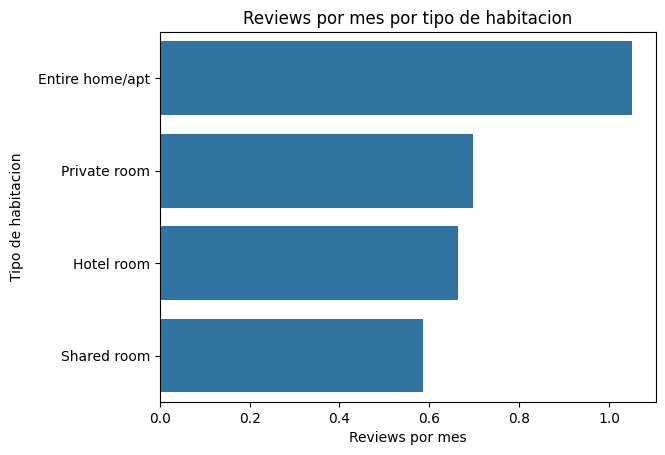

In [217]:
reviews_por_mes_barrio = estambul.groupby("room_type").reviews_per_month.mean().sort_values(ascending=False)

sns.barplot(y=reviews_por_mes_barrio.index, x=reviews_por_mes_barrio.values, orient="h", width= 0.8)
plt.title("Reviews por mes por tipo de habitacion")
plt.xlabel("Reviews por mes")
plt.ylabel("Tipo de habitacion", labelpad = 10)

plt.show()

In [218]:
def manejar_outliers(df):
    outliers_indices = []
    for col in df.columns:
      mean_value = estambul_num[col].mean()
      std_value = estambul_num[col].std()
      z_scores = (estambul_num[col] - mean_value) / std_value

      outliers_col = df.loc[(z_scores > 2) | (z_scores <-2), col]
      if outliers_col.shape[0] > 0:

          outliers_indices.extend(outliers_col.index.tolist())
          if estambul[col].dtype in ['int64', 'int32']:
              estambul[col] = estambul[col].astype('float64')
          estambul[col] = np.log1p(estambul[col])
    estambul.drop(index=outliers_indices, inplace=True)
estambul_num = estambul.select_dtypes(include=np.number)
estambul_num = estambul_num.drop(columns=["id", "host_id", "mes_last_review", "dia_last_review", "latitude", "longitude"])

manejar_outliers(estambul_num)

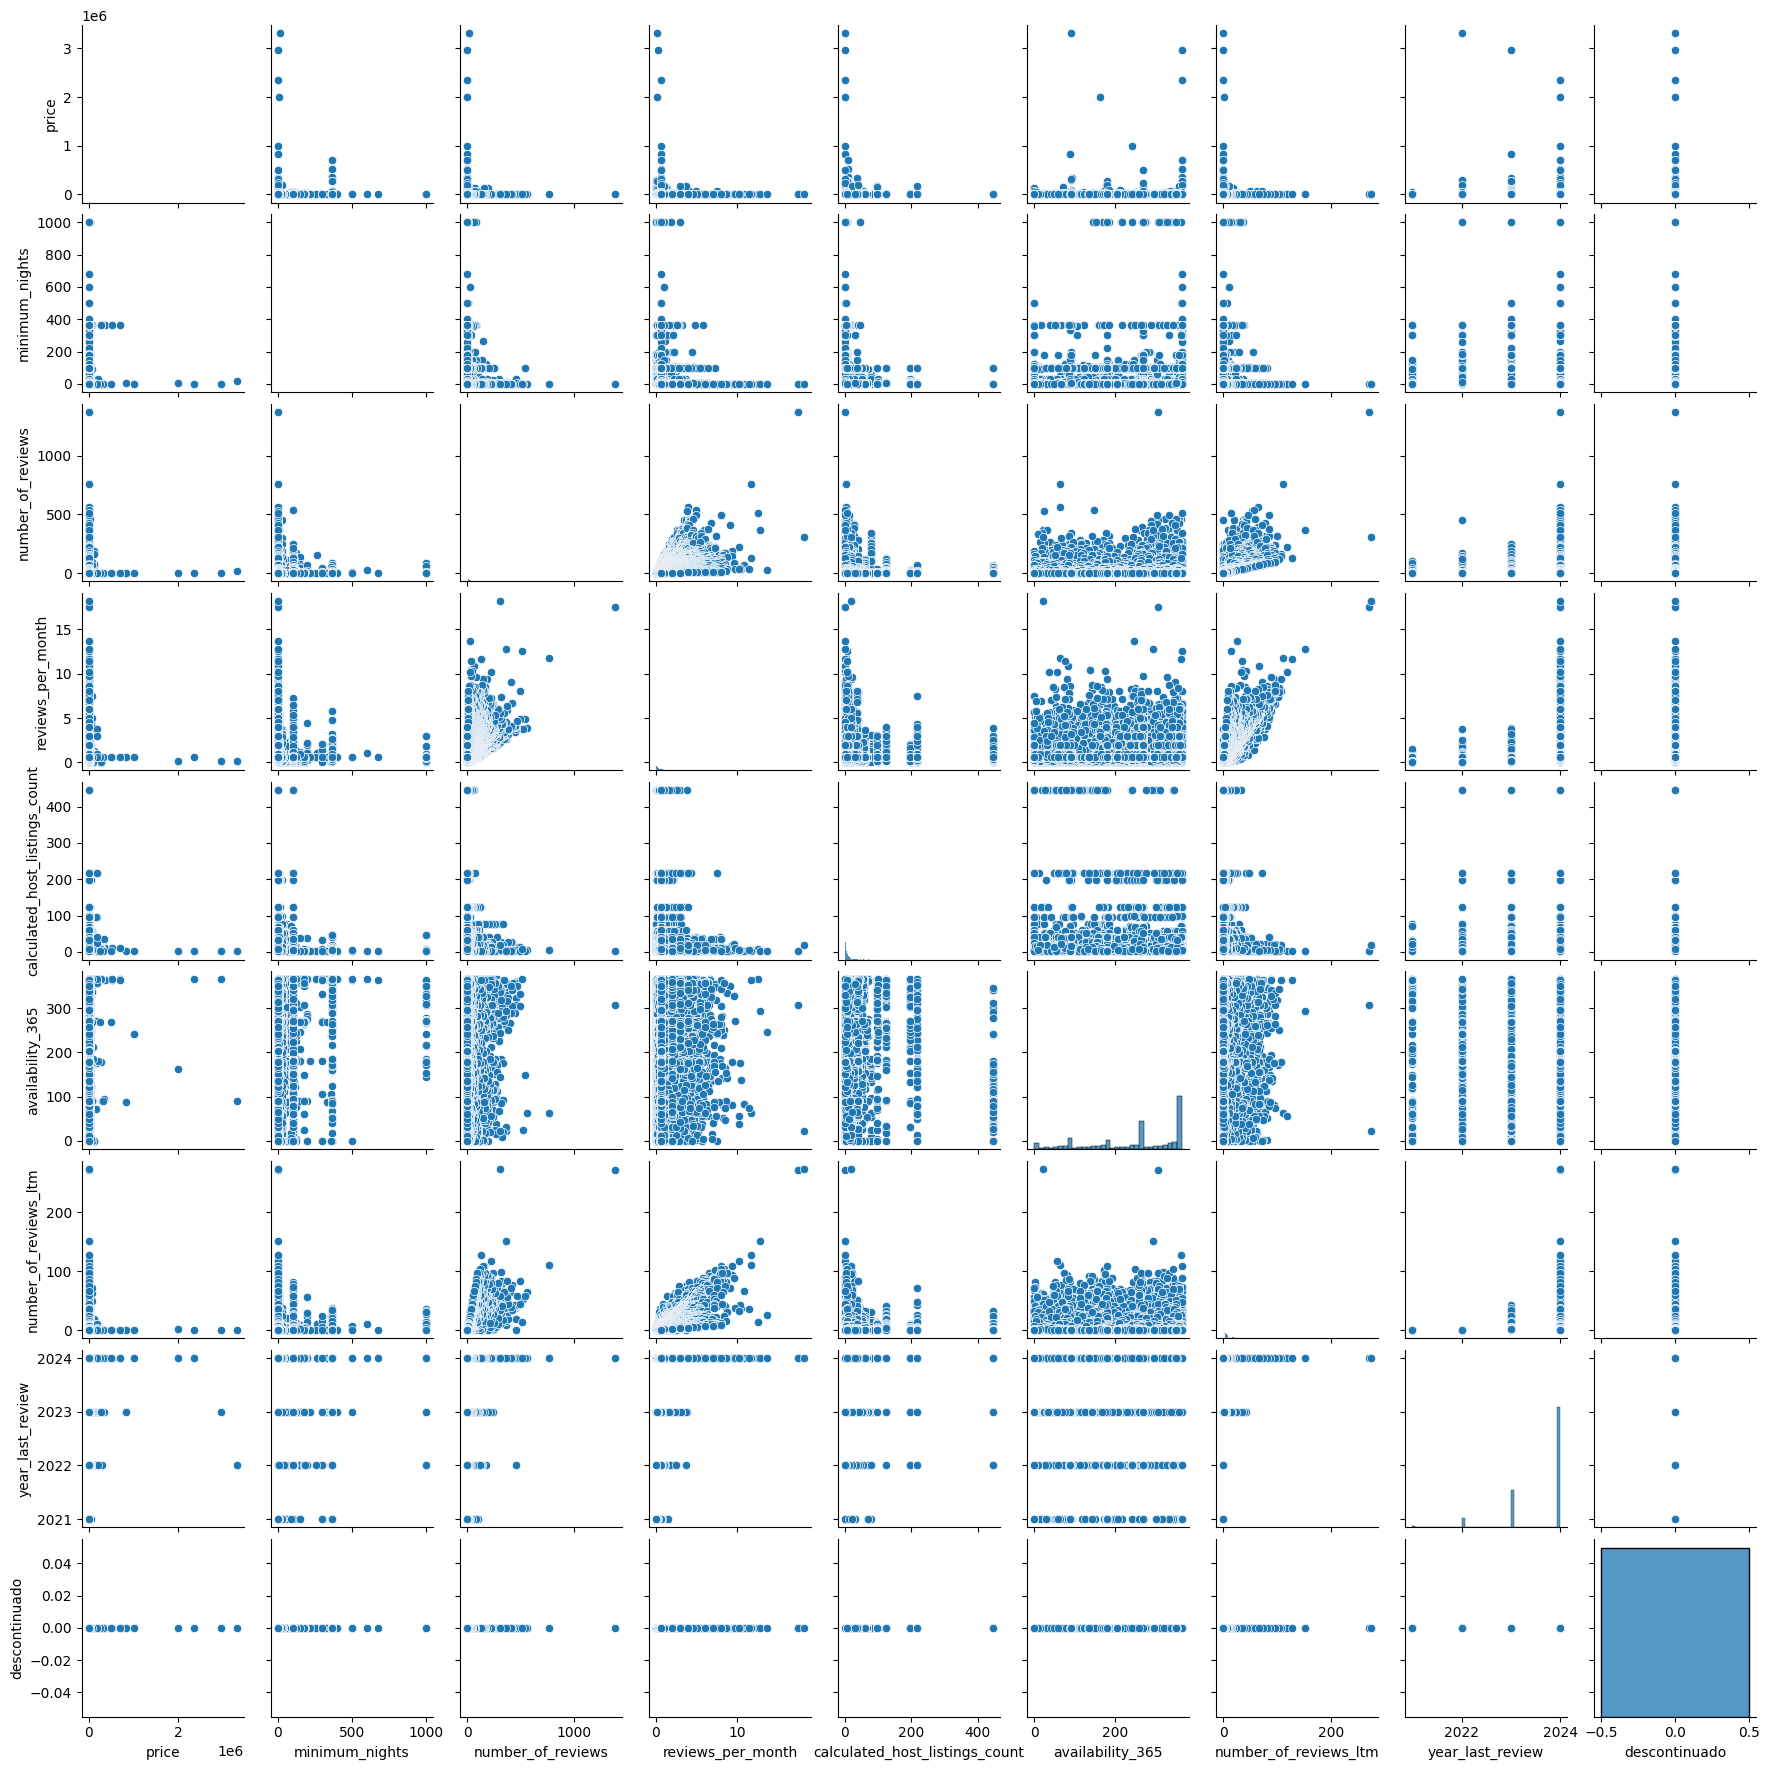

In [219]:
sns.pairplot(estambul_num, height=2)

In [220]:
def categorizar_valores(serie,x):
  topx_valores = serie.value_counts().head(x).index
  return serie.apply(lambda x: x if x in topx_valores else "otros")

estambul["neighbourhood"] = categorizar_valores(estambul["neighbourhood"],10)
estambul["license"] = categorizar_valores(estambul["license"],10)

# Entrenamiento y Predicción


In [221]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [222]:
features = estambul.drop(columns=["price", "host_name", "name", "host_id", "id"])
target = estambul.price

## Modelo 1 : Regresión lineal


In [223]:
regresion = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(features, target,test_size=0.2, random_state=42)

In [224]:
columnas_categoricas = X_train.select_dtypes(include="object").columns
X_train = pd.get_dummies(X_train, columns=columnas_categoricas,drop_first=True)
X_test = pd.get_dummies(X_test, columns=columnas_categoricas,drop_first=True)
col = X_train.columns
escalado = StandardScaler()
X_train = escalado.fit_transform(X_train)
X_test = escalado.transform(X_test)

In [225]:
regresion.fit(X_train, y_train)

LinearRegression()

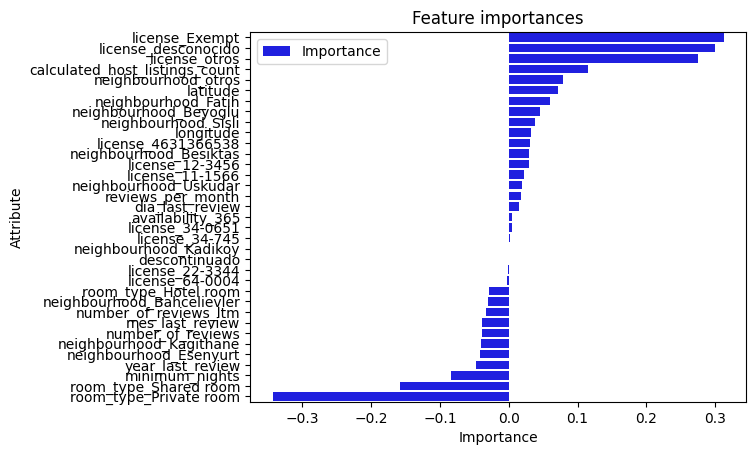

In [226]:
importances = pd.DataFrame(data={
    'Attribute': col,
    'Importance': regresion.coef_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Attribute')

sns.barplot(x='Importance', y=importances.index, data=importances,
            label='Importance', color='b')
plt.xlabel('Importance')
plt.ylabel('Attribute')
plt.title('Feature importances')
plt.show()

In [227]:
cv_scores = cross_val_score(regresion, X_train, y_train, cv=5, scoring='r2')
cv_r2 = np.mean(cv_scores)
print(f"Validación cruzada R2: {cv_r2:.2f}")

Validación cruzada R2: 0.27


In [228]:
y_train_pred = regresion.predict(X_train)
y_test_pred = regresion.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("Performance en el conjunto de entrenamiento:")
print(f"MSE: {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"R2: {r2_train:.2f}")

print("\nPerformance en el conjunto de prueba:")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R2: {r2_test:.2f}")

Performance en el conjunto de entrenamiento:
MSE: 0.48
RMSE: 0.70
R2: 0.27

Performance en el conjunto de prueba:
MSE: 0.45
RMSE: 0.67
R2: 0.30


## Modelo 2: XGBoost


In [229]:
import xgboost as xgb
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [230]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(features, target,test_size=0.2, random_state=42)

In [231]:
columnas_categoricas = X_train_xgb.select_dtypes(include="object").columns
X_train_xgb = pd.get_dummies(X_train_xgb, columns=columnas_categoricas,drop_first=True)
X_test_xgb = pd.get_dummies(X_test_xgb, columns=columnas_categoricas,drop_first=True)
col = X_train_xgb.columns
escalado = StandardScaler()
X_train_xgb = escalado.fit_transform(X_train_xgb)
X_test_xgb = escalado.transform(X_test_xgb)

In [232]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 1000, min_child_weight=300, subsample=0.8, eta=0.3)

In [233]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20,30],
    'min_child_weight': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train_xgb, y_train_xgb)

best_model = grid_search.best_estimator_

print("Model:", best_model)

Model: XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, ...)


In [234]:
best_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, ...)

In [235]:
y_train_xgb_pred = best_model.predict(X_train_xgb)
y_test_xgb_pred = best_model.predict(X_test_xgb)

mse_train_xgb = mean_squared_error(y_train_xgb, y_train_xgb_pred)
rmse_train_xgb = np.sqrt(mse_train_xgb)
r2_train_xgb = r2_score(y_train_xgb, y_train_xgb_pred)

mse_test_xgb = mean_squared_error(y_test_xgb, y_test_xgb_pred)
rmse_test_xgb = np.sqrt(mse_test_xgb)
r2_test_xgb = r2_score(y_test_xgb, y_test_xgb_pred)

print("Performance en el conjunto de entrenamiento:")
print(f"MSE: {mse_train_xgb:.2f}")
print(f"RMSE: {rmse_train_xgb:.2f}")
print(f"R2: {r2_train_xgb:.2f}")

print("\nPerformance en el conjunto de prueba:")
print(f"MSE: {mse_test_xgb:.2f}")
print(f"RMSE: {rmse_test_xgb:.2f}")
print(f"R2: {r2_test_xgb:.2f}")

Performance en el conjunto de entrenamiento:
MSE: 0.18
RMSE: 0.42
R2: 0.73

Performance en el conjunto de prueba:
MSE: 0.32
RMSE: 0.57
R2: 0.50


## Modelo 3: lightgbm


In [236]:
import lightgbm as lgb

In [237]:
from sklearn.model_selection import RandomizedSearchCV

In [238]:
X_train_GBM, X_test_GBM, y_train_GBM, y_test_GBM = train_test_split(features, target,test_size=0.2, random_state=42)
columnas_categoricas = X_train_GBM.select_dtypes(include="object").columns
X_train_GBM = pd.get_dummies(X_train_GBM, columns=columnas_categoricas,drop_first=True)
X_test_GBM = pd.get_dummies(X_test_GBM, columns=columnas_categoricas,drop_first=True)
col = X_train_GBM.columns
escalado = StandardScaler()
X_train_GBM = escalado.fit_transform(X_train_GBM)
X_test_GBM = escalado.transform(X_test_GBM)

In [239]:
lgb_model = lgb.LGBMRegressor(random_state=42)
random_search = RandomizedSearchCV(lgb_model, param_distributions=param_grid,
                                   cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, random_state=42)

random_search.fit(X_train_GBM, y_train_GBM)

best_params = random_search.best_params_
print("Mejores parámetros:", best_params)
best_model = random_search.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 19146, number of used features: 29
[LightGBM] [Info] Start training from score 7.604029
Mejores parámetros: {'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 30}


In [240]:
best_model.fit(X_train_GBM, y_train_GBM)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 19146, number of used features: 29
[LightGBM] [Info] Start training from score 7.604029


LGBMRegressor(max_depth=30, min_child_weight=10, n_estimators=200,
              random_state=42)

In [241]:
cv_scores = cross_val_score(best_model, X_train_GBM, y_train_GBM, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Validación cruzada RMSE: {cv_rmse.mean():.2f} (+/- {cv_rmse.std() * 2:.2f})")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 15316, number of used features: 28
[LightGBM] [Info] Start training from score 7.602760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 15317, number of used features: 29
[LightGBM] [Info] Start training from score 7.602522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [242]:
def metricas(y_true, y_pred):

  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)


  print(f"RMSE: {rmse:.2f}")
  print(f"MSE: {mse:.2f}")
  print(f"R2: {r2:.2f}\n")

print("Performance en el conjunto de entrenamiento:")
metricas(y_train_GBM, best_model.predict(X_train_GBM))
print("Performance en el conjunto de test:")
metricas(y_test_GBM, best_model.predict(X_test_GBM))


Performance en el conjunto de entrenamiento:
RMSE: 0.51
MSE: 0.26
R2: 0.60

Performance en el conjunto de test:
RMSE: 0.57
MSE: 0.32
R2: 0.50



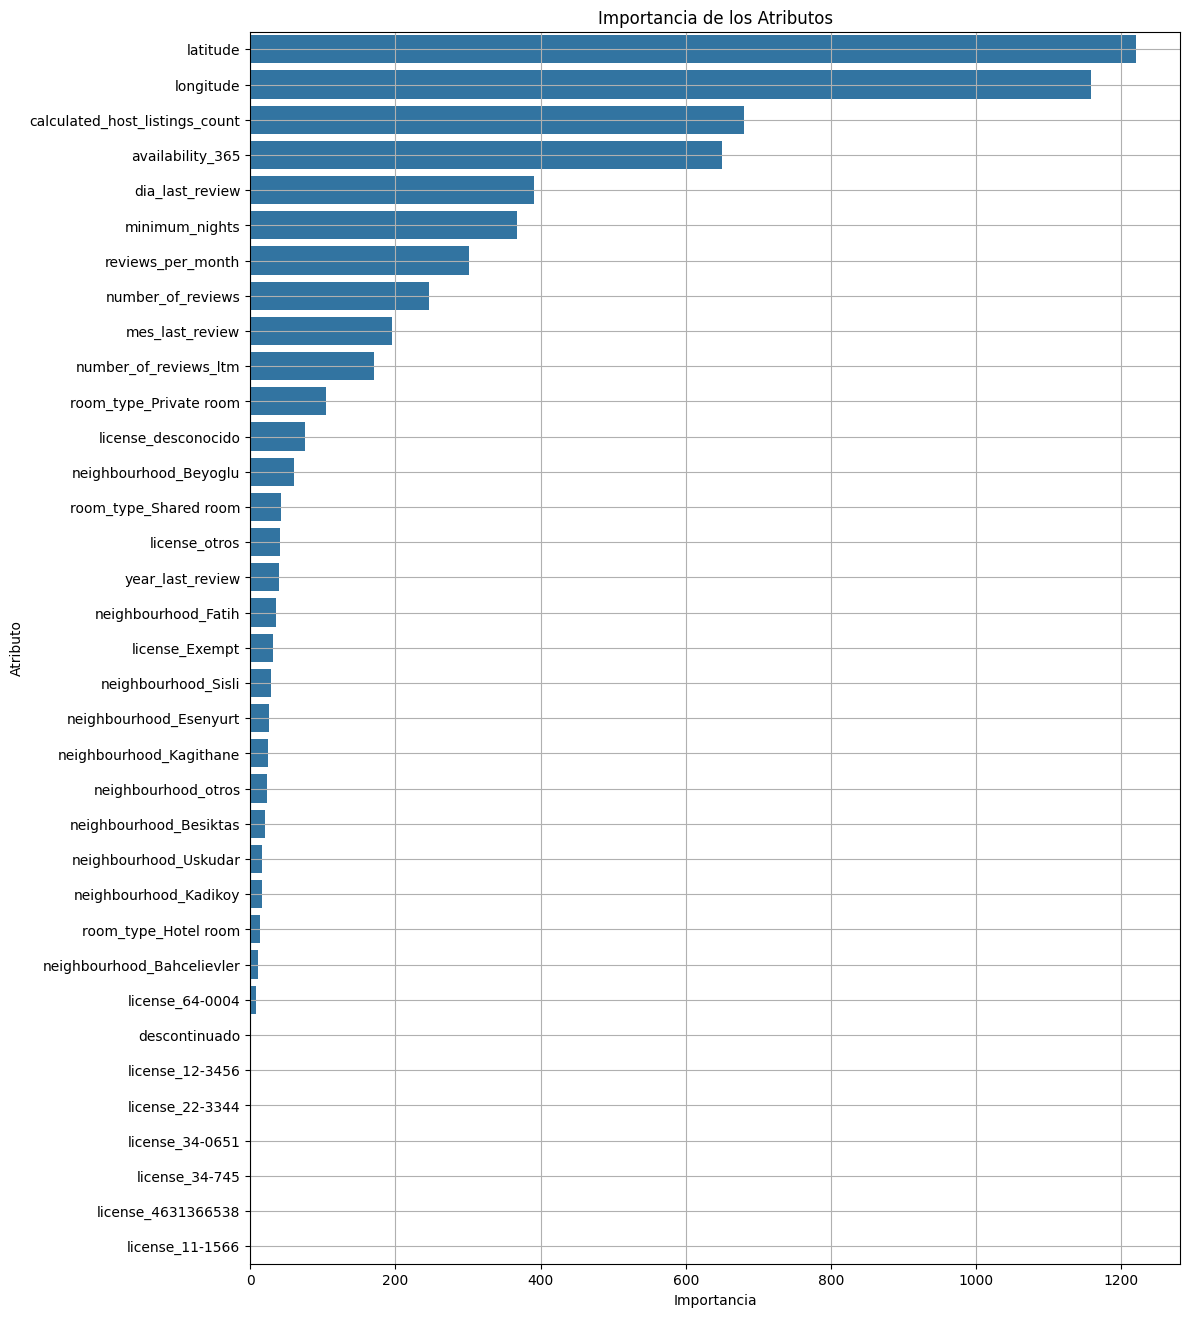

In [243]:
feature_importances = pd.DataFrame(best_model.feature_importances_, index=col, columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(12,16))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Importancia de los Atributos')
plt.xlabel('Importancia')
plt.ylabel('Atributo')
plt.grid(True)
plt.show()